In [66]:
import numpy as np
from fairchem.core.preprocessing.atoms_to_graphs import AtomsToGraphs
from ase.io import read
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from ase.visualize import view
import torch
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import mean_absolute_error

In [ ]:
# Install required packages
!pip install -r requirements.txt

### Dataset

creating dataset with geometric pytorch objects using ASE and Fairchem libraries

In [27]:
# Read from processed as we need names of the cif files
df = pd.read_csv("../data/processed_MOFs.csv")

# Start by using 10% of the data since it is computationally heavy
df_sample = df.sample(frac=0.1, random_state=42)

# Create dataframe with mofname and empty ASE column
df_x = df_sample['MOFname'].copy()
df_x = df_x.to_frame('MOFname')
df_x['ase'] = None

y = df_sample.pop('CO2_uptake_P0.15bar_T298K [mmol/g]')
y = y.to_frame('uptake')

print(df_x.shape)
print(y.shape)

(32443, 2)
(32443, 1)


In [28]:

# IMPORTANT: Input path to cif file dataset
path = "" 

# read the cif files using ASE (Atomic Simulation Environment) and add the object to the ase column
for (root, dirs, file) in os.walk(path):
    for f in file:
        # Remove the `.cif` extension from the file name before comparing
        base_name = os.path.splitext(f)[0]
        if base_name in df_sample['MOFname'].values:
            index = df_x.loc[df_x['MOFname'] == base_name].index[0]
            df_x.at[index, 'ase'] = read(path+f)


atg = AtomsToGraphs()
# Convert ase to graph (pytorch geometric data)
df_x['graph'] = df_x['ase'].apply(atg.convert)

df_x.head()

/usr/local/lib/python3.11/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'triclinic' is not interpreted for space group 1. This may result in wrong setting!
  warnings.warn(
/usr/local/lib/python3.11/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'monoclinic' is not interpreted for space group 1. This may result in wrong setting!
  warnings.warn(
/usr/local/lib/python3.11/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'orthorhombic' is not interpreted for space group 1. This may result in wrong setting!
  warnings.warn(
/usr/local/lib/python3.11/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'tetragonal' is not interpreted for space group 1. This may result in wrong setting!
  warnings.warn(
/usr/local/lib/python3.11/site-packages/ase/spacegroup/spacegroup.py:430: UserWarning: scaled_positions 109 and 110 are equivalent
  warnings.warn('scaled_positions %d and %d '
/usr/local/lib/python3.11/site-packages/ase/spacegroup/spacegroup.

,MOFname,ase,graph
149608,str_m5_o8_o8_sra_sym.4,"(Atom('O', [4.972927701279999, 18.553706683199...","[(pos, [tensor([ 4.9729, 18.5537, 4.9390]), t..."
22600,str_m3_o11_o29_pcu_sym.44,"(Atom('C', [13.912779587381603, 2.828166755619...","[(pos, [tensor([13.9128, 2.8282, 4.9946]), t..."
195190,str_m4_o4_o19_acs_sym.59,"(Atom('C', [8.081190026020296, 1.1147383456811...","[(pos, [tensor([ 8.0812, 1.1147, 11.6924]), t..."
120233,str_m6_o43_o45_etb_sym.76,"(Atom('P', [6.520856850936906, 10.093167599973...","[(pos, [tensor([ 6.5209, 10.0932, 10.5512]), t..."
321648,str_m4_o14_o14_acs_sym.120,"(Atom('C', [3.357482226572825, 4.4653483087240...","[(pos, [tensor([3.3575, 4.4653, 2.7581]), tens..."


In [29]:
# Split data with defined ratios
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=1 - train_ratio, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

print(x_train.shape, x_val.shape, x_test.shape)

(24332, 3) (4866, 3) (3245, 3)


In [57]:

# Create Data objects 
train_data = [Data(pos=g['pos'], cell=g['cell'], atomic_numbers=g['atomic_numbers'], edge_index=g['edge_index'], edge_attr=g['edge_distance_vec'], y=torch.tensor(y, dtype=torch.float)) for g, y in zip(x_train['graph'].tolist(), y_train['uptake'].tolist())] 
val_data = [Data(pos=g['pos'], cell=g['cell'], atomic_numbers=g['atomic_numbers'], edge_index=g['edge_index'], edge_attr=g['edge_distance_vec'], y=torch.tensor(y, dtype=torch.float)) for g, y in zip(x_val['graph'].tolist(), y_val['uptake'].tolist())] 
test_data = [Data(pos=g['pos'], cell=g['cell'], atomic_numbers=g['atomic_numbers'], edge_index=g['edge_index'], edge_attr=g['edge_distance_vec'], y=torch.tensor(y, dtype=torch.float)) for g, y in zip(x_test['graph'].tolist(), y_test['uptake'].tolist())] 

# create data object for prediction
def data_objects_for_predict(data):
    return Data(pos=data['pos'], cell=data['cell'], atomic_numbers=data['atomic_numbers'], edge_index=data['edge_index'], edge_attr=data['edge_distance_vec'])

# Create node feature matrix of graph
def feature_node_matrix(data):
        atomic_numbers = data.atomic_numbers.view(-1, 1).float()  # Shape: [num_nodes, 1]
        pos = data.pos  # Shape: [num_nodes, 3]
        data.x = torch.cat([atomic_numbers, pos], dim=1)  # Shape: [num_nodes, 4]

# Node feature matrix for all datasets
for data in train_data + val_data + test_data:
        feature_node_matrix(data)


### Visualizing structures and graphs

In [31]:
# first atom structure and graph in the dataframe
atom = df_x.iloc[0,1]
graph = df_x.iloc[0,2]

view(atom, viewer='x3d')

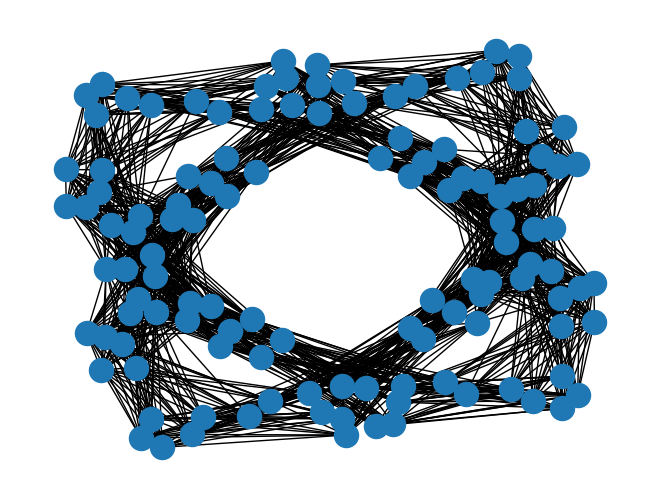

In [26]:
# Display with networkx library
graph = to_networkx(graph, to_undirected=True)
nx.draw(graph)

### Graph Convolutional Network

In [33]:
# Graph Convolutional Network for regression
class GCNRegression(torch.nn.Module):
    def __init__(self, hidden_channels):
        """
        Initialize the GCN regression model.

        Parameters:
        hidden_channels (int): Number of hidden units in the graph convolution layers.
        """
        super(GCNRegression, self).__init__()
        self.conv1 = GCNConv(4, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        """
        Forward pass through the model.

        Parameters:
        data: A data object containing graph information (.
            - data.x: Node feature matrix.
            - data.edge_index: Edge connectivity (graph structure).
            - data.batch: Batch indices for mini-batch processing.

        Returns:
        torch.Tensor: Predicted regression values for each graph in the batch.
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(-1)


In [34]:
class GraphConvolutionalNeuralNet():
  def __init__(self, model):
    self.model = model
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_loss_per_epoch': [],
        'validation_loss_per_epoch': [],
    } 

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)

    #  setting model to training mode
    self.model.train()

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #  training
      for data in train_loader:
        self.optimizer.zero_grad()
        predictions = self.model(data)
        loss = loss_function(predictions, data.y)
        log_dict['training_loss_per_batch'].append(loss.item())
        train_losses.append(loss.item())
        loss.backward()
        self.optimizer.step()

      #  validation, setting model to evaluation mode
      self.model.eval()
      val_losses = []
      with torch.no_grad():
        for data in val_loader:
          predictions = self.model(data)
          val_loss = loss_function(predictions, data.y)
          log_dict['validation_loss_per_batch'].append(val_loss.item())
          val_losses.append(val_loss.item())

      train_losses = np.array(train_losses).mean()
      val_losses = np.array(val_losses).mean()
      log_dict['training_loss_per_epoch'].append(train_losses)
      log_dict['validation_loss_per_epoch'].append(val_losses)
      print(f'training_loss: {train_losses}   validation_loss: {val_losses} \n')
    
    # Save the model
    torch.save(self.model.state_dict(), 'gcn_model.pth')

    return log_dict

  def predict(self, data):
    return self.model(data)

In [36]:
# Init model and training/validation
loss_fn = torch.nn.MSELoss()
batch_size = 64

regression_network = GCNRegression(batch_size)
model = GraphConvolutionalNeuralNet(regression_network)

log_dict = model.train(loss_function=loss_fn, epochs=10, batch_size=batch_size, 
                       training_set=train_data, validation_set=val_data)


Epoch 1/10
training_loss: 0.32695424551843344   validation_loss: 0.26201156986417706 

Epoch 2/10
training_loss: 0.23204938374127304   validation_loss: 0.2279595093100102 

Epoch 3/10
training_loss: 0.22116426480176254   validation_loss: 0.2221015634668338 

Epoch 4/10
training_loss: 0.21607596395913697   validation_loss: 0.2204310538900363 

Epoch 5/10
training_loss: 0.21347743648243703   validation_loss: 0.21922249927536233 

Epoch 6/10
training_loss: 0.21159633427486801   validation_loss: 0.21737453622090352 

Epoch 7/10
training_loss: 0.2101477732847682   validation_loss: 0.21439845840652266 

Epoch 8/10
training_loss: 0.20813207788847563   validation_loss: 0.21020056791119762 

Epoch 9/10
training_loss: 0.2063690475982631   validation_loss: 0.21091044568396233 

Epoch 10/10
training_loss: 0.20486728797160733   validation_loss: 0.20495410505440328 



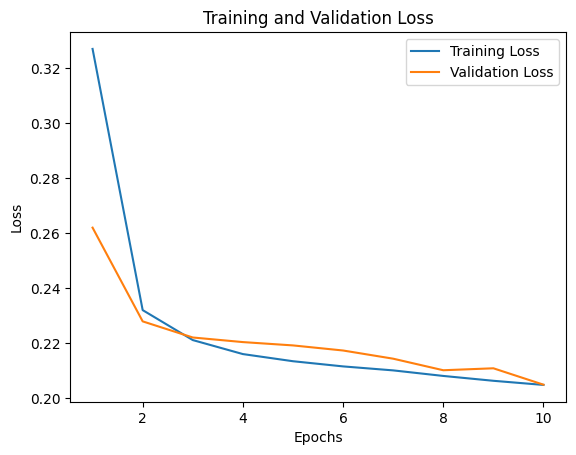

In [37]:

# Plot and label the training and validation loss values
epochs = range(1, len(log_dict['training_loss_per_epoch'])+1)
plt.plot(epochs, log_dict['training_loss_per_epoch'], label='Training Loss')
plt.plot(epochs, log_dict['validation_loss_per_epoch'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [74]:
preds = []
y_vals = []

# Predict on the test data and print the MAE
for data in test_data:
    pred = model.predict(data)
    preds.append(pred.item())
    y_vals.append(data.y.item())

print(mean_absolute_error(preds, y_vals))

0.25840871387269454
